In [1]:
library(fields)
library(coda)
library(ggplot2)
library(mgcv)
#library(mvtnorm)

Loading required package: spam

Loading required package: dotCall64

Loading required package: grid

Spam version 2.6-0 (2020-12-14) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: ‘spam’


The following objects are masked from ‘package:base’:

    backsolve, forwardsolve


See https://github.com/NCAR/Fields for
 an extensive vignette, other supplements and source code 

Loading required package: nlme

This is mgcv 1.8-33. For overview type 'help("mgcv-package")'.



# (Markov Chain) Monte-Carlo Sampling

We wish to make inferences about the mean $\mu$ and variance $v = 1/\tau$ of a Normal distribution given some data $x = \{x_{i}\}$ that is supposed independent give the parameters of interest, and other prior knowledge $K$ that we will discuss in a moment. We are therefore interested in the distribution $P(\mu, \tau \mid x, K)$. This can be re-expressed as 

$$
P(\mu, \tau \mid x, K) \propto P(x \mid \mu, \tau, K) \: P(\mu, \tau \mid K)
$$

Write down the probability of the data given $\mu$ and $\tau$ as a detailed formula. 

$$
P(x \mid \mu, \tau, K) = \prod_{i} dx_{i} \: P(x_{i} \mid \mu, \tau, K) = dx\prod_{i} \sqrt{\tau \over 2\pi}\: \exp\bigl(-{\tau\over 2}(x_{i} - \mu)^{2}\bigr)
$$

We will now generate some synthetic data by sampling from this distribution. Since the $x_{i}$ are independent, we can sample them separately. First we pick values for $\mu$ and $\tau$: $\mu = 10$ and $\tau = 0.25$, corresponding to $v = 4$ or $\sigma = 2$. Write a function to generate $n$ samples from this distribution (this is really just a wrapper for the `rnorm` function), then generate $1000$ points and plot them as a histogram.

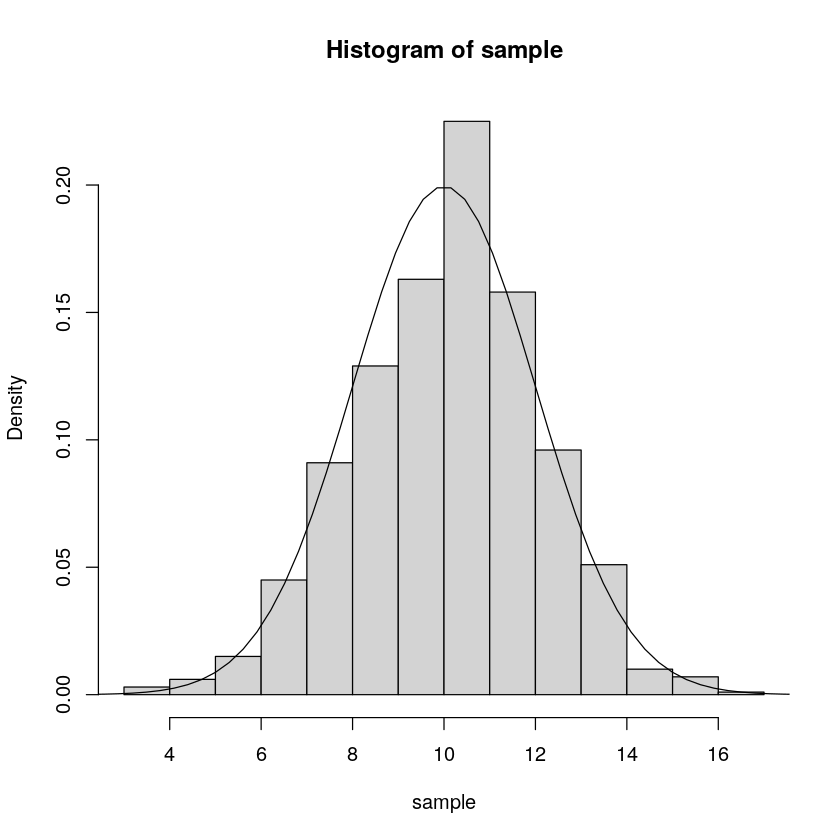

In [2]:
sampleNorm = function(n){
    
    mu = 10
    v = 4
    
    sample = rnorm(n, mu, sqrt(v))
    
    return(sample)
    
}

sample = sampleNorm(1000)

hist(sample, freq = FALSE)

xs = seq(-5, 25, len = 100)
ys = dnorm(xs, 10, sqrt(4))
lines(xs, ys, type = 'l')

To complete the inference, we need a prior distribution. We will use a conjugate prior for $\mu$ and $\tau$, the Normal-Gamma distribution. Look up and write down the prior probability of $\mu$ and $\tau$ in detail. 

$$
P(\mu, \tau \mid m, \nu, \alpha, \beta) \propto \tau^{\alpha - {1\over 2}}\: e^{-\beta\tau}\: \exp\bigl(-{\nu\tau(\mu - m)^{2} \over 2}\bigr)
$$

Write a function to compute this density.

In [3]:
dNormGamma = function(x, params){
    
    mu = x[1]
    tau = x[2]
    
#     print(paste('mu', mu))
#     print(paste('tau', tau))
    
    m = params$m
    nu = params$nu
    alpha = params$alpha
    beta = params$beta
    
#     print(paste('m', m))
#      print(paste('nu', nu))
#      print(paste('alpha', alpha))
#      print(paste('beta', beta))
    
    dTau = dgamma(tau, alpha + 0.5, beta)
    
  
    
    dMuGivenTau = dnorm(mu, m, sqrt(1/(nu*tau)))
    
#     print(paste('dTau', dTau))
#     print(paste('dMu', dMuGivenTau))
    
    dens = dMuGivenTau * dTau
    
    return(dens)

}

Look up or calculate the form of the distribution $P(\mu, \tau \mid x, K)$, in particular, the values of its parameters.

The distribution $P(\mu, \tau \mid x, K)$ is also normal-gamma with parameters

$$
\begin{align*}
m' & = {n \bar{x} + \nu m \over n + \nu} \\
\nu' & = n + \nu \\
\alpha' & = {n \over 2} + \alpha \\
\beta' & = {n \over 2}\overline{(x - \bar{x})^{2}} + {n\nu \over n + \nu}{(\bar{x} - m)^{2} \over 2} + \beta
\end{align*}
$$

Write a function that takes data and prior parameters as input, and that returns the posterior parameters.

In [4]:
updateParams = function(x, params){
    
    n = length(x)
    xbar = mean(x)
    v = ((n-1)/n)*var(x)
    
    m = params$m
    nu = params$nu
    alpha = params$alpha
    beta = params$beta
    
    newparams = vector(mode = 'list')
    
    newparams$m = (n*xbar + nu*m)/(n + nu)
    newparams$nu = n + nu
    newparams$alpha = (n/2) + alpha 
    newparams$beta = (n/2)*v + (n*nu/(n + nu))*(xbar - m)^(2)/2 + beta
    
    return(newparams)
    
}

In fact, we can sample quite simply from the Normal-Gamma distribution because the breakdown $P(\mu, \tau \mid x, K) = P(\mu \mid \tau, x, K)\: P(\tau \mid x, K)$ is easy to perform: the marginal distribtuion of $\tau$ is Gamma, while the distribution of $m$ conditioned on $\tau$ is Normal (hence the name of the distribution). We can thus sample $\tau$ and then for each sampled $\tau$ sample one or more $\mu$ values. Write a function (using `rgamma` and `rnorm`) that takes the Normal-Gamma distribution parameters and generates $n$ samples this way. This serves as a useful point of reference.

In [5]:
sampleNormGamma1 = function(params){
    
    m = params$m
    nu = params$nu
    alpha = params$alpha
    beta = params$beta
    
    tau = rgamma(1, alpha + 0.5, beta)
    
    mu = rnorm(1, m, sqrt(1/(nu*tau)))
    
    return(c(mu, tau))
}

sampleNormGamma = function(N, params){
    
    sample = sapply(1:N, function(i){sampleNormGamma1(params)})
    
    return(sample)
}



Make another function to make trace plots of the sequences of $\mu$ and $\tau$ samples, and another to compute and plot the autocorrelation (you can use the package `coda` for this), and to compute and print out the MC estimates of mean and variance, the effective sample size, and MCMC standard error. For the second function, you should include an argument to the function representing the number of burn-in samples, which should then be discarded before computing the above quantities.

In [6]:
plotMuTauSamp = function(sample){
    
    mus = sample[1,]
    taus = sample[2,]
    
    par(mfrow = c(2, 1))
    plot(mus, type = 'l')
    plot(taus, type = 'l')
    
    dfsample = as.data.frame(t(sample))
    names(dfsample) = c('mu', 'tau')
    
    plot(dfsample)
    
#     ggplot(dfsample, aes(x=mus, y=taus)) + 
#     stat_density_2d(aes(fill = ..level..), geom = "polygon", colour="white") +
#     scale_fill_distiller(palette= "Spectral", direction=1)
    
    
}

computeAndPlotACFetc = function(sample, bi){
    
    mus = sample[1,]
    taus= sample[2,]
  
    # acf(mus)
    # acf(taus)

    
    dfsample = as.data.frame(t(sample))
    names(dfsample) = c('mu', 'tau')
    
    plot(dfsample, ylim = c(0, max(dfsample$tau)), type = 'l')

    
    # Subtract burn-in
    vmus = mus[(bi + 1):length(mus)]
    vtaus = taus[(bi + 1):length(taus)]
    vdfsample = dfsample[(bi + 1):nrow(dfsample),]
    
    rhomu = acf(vmus)$acf
    rhotau = acf(vtaus)$acf
  
    print(paste("Estimated expected value of mu is:", mean(vmus)))
    print(paste("Estimated expected value of tau is:", mean(vtaus)))
    
    print(paste("Estimated standard deviation of mu is:", sd(vmus)))
    print(paste("Estimated standard deviation of tau is:", sd(vtaus)))
    
    x = mcmc(data = vdfsample)

    summary(x)
    
    plot(x)
    
    # print(effectiveSize(x))
    
    ESSmu = effectiveSize(vmus)
    ESStau = effectiveSize(vtaus)
        
    print(paste("Effective sample size for mu is:", ESSmu))    
    print(paste("Effective sample size for tau is:", ESStau))    
    
    print(paste("MCMC standard error of mu is:", sd(vmus)/ESSmu))
    print(paste("MCMC standard error of tau is:", sd(vtaus)/ESStau))

    
    
}

Try picking $\alpha = 0.5$, $\beta = 0.01$, $\nu = 0.01$, and $m = 0$ for the hyperparameters. Generate different numbers of samples of data with $\mu = 10$ and $\tau = 0.25$, compute the posterior parameters, and then sample and plot $1000$ values from the posterior. 

$m
[1] 10.01055

$nu
[1] 1000.01

$alpha
[1] 500.5

$beta
[1] 2059.295

[1] "Between"


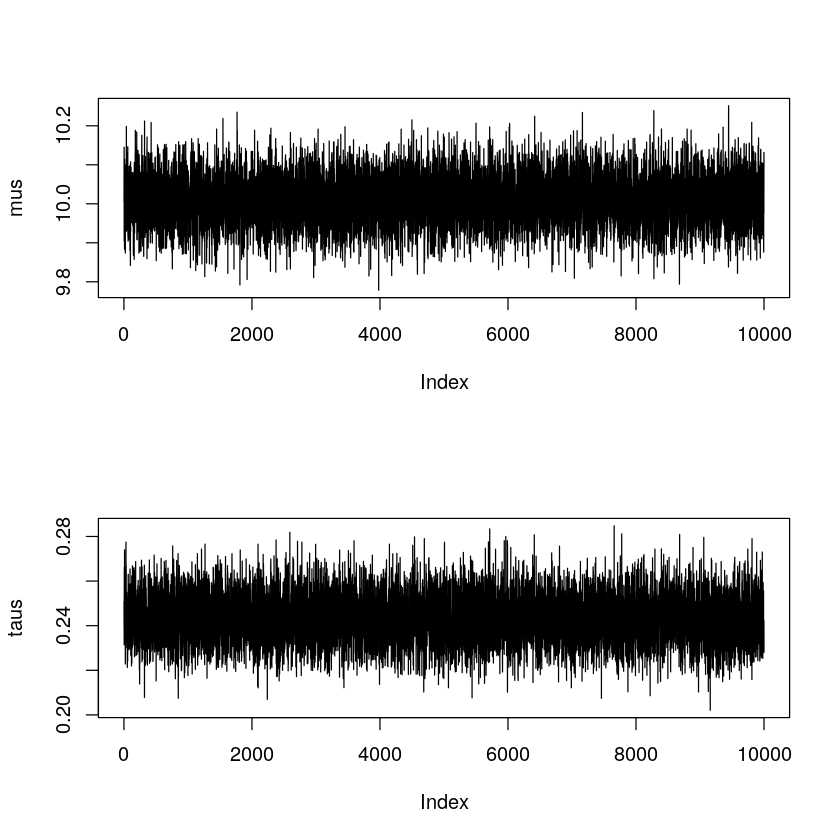

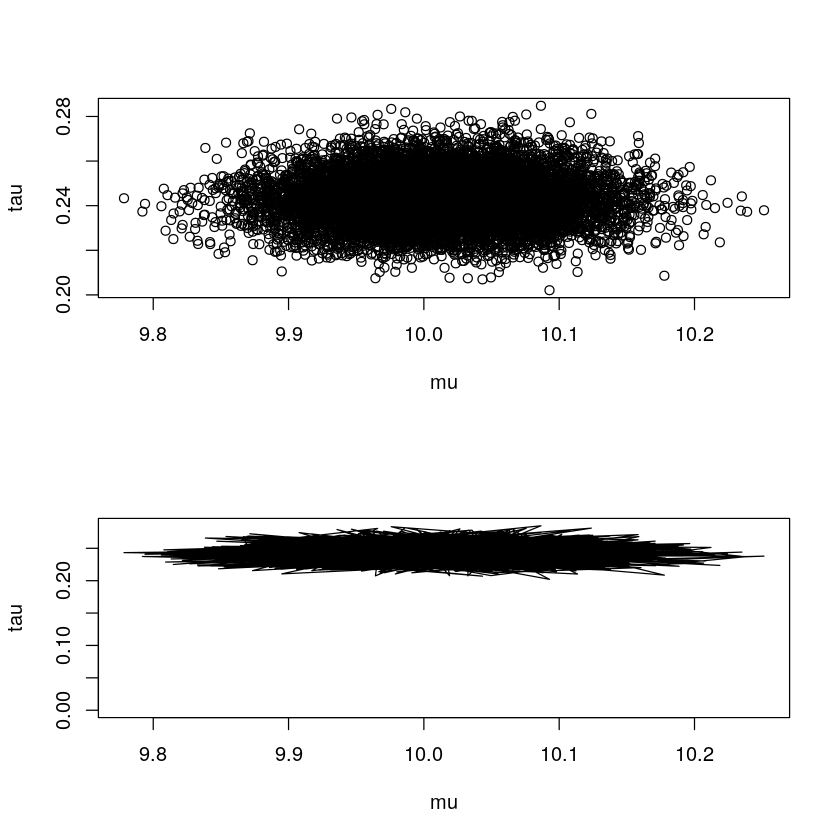

[1] "Estimated expected value of mu is: 10.0104554862809"
[1] "Estimated expected value of tau is: 0.242994067713979"
[1] "Estimated standard deviation of mu is: 0.063848327951915"
[1] "Estimated standard deviation of tau is: 0.0109608975915708"


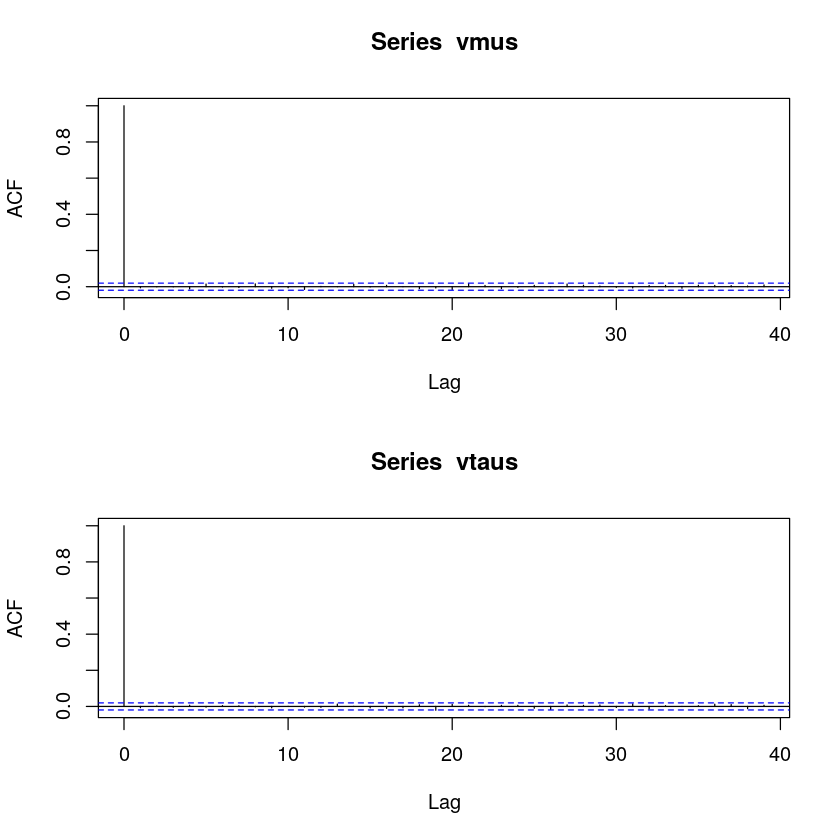

[1] "Effective sample size for mu is: 9989.99999999997"
[1] "Effective sample size for tau is: 9990.00000000005"
[1] "MCMC standard error of mu is: 6.39122401921073e-06"
[1] "MCMC standard error of tau is: 1.09718694610317e-06"


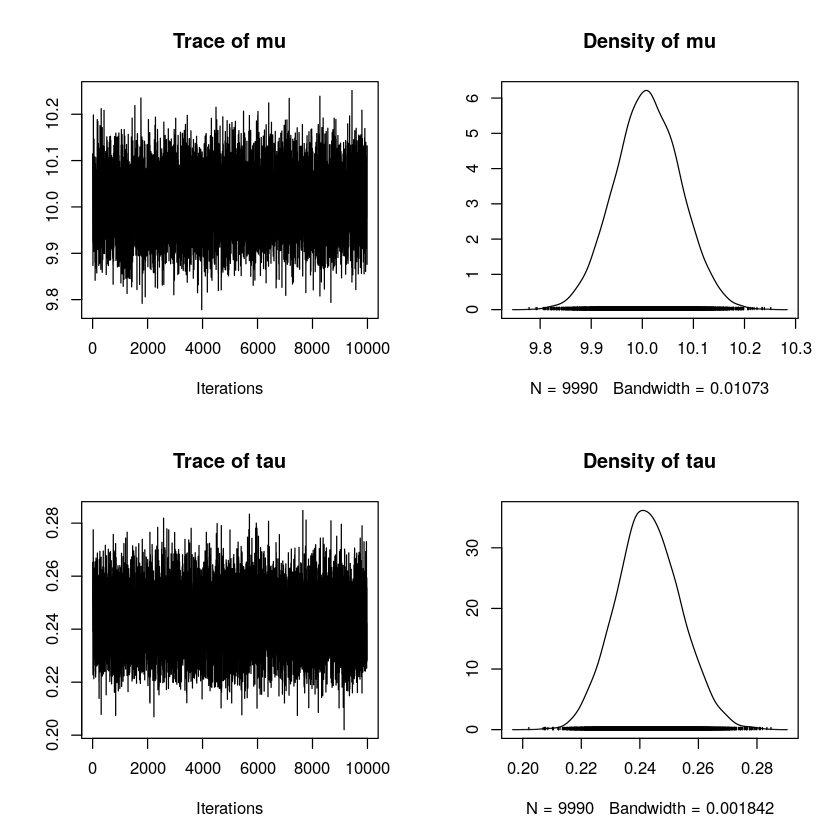

In [7]:
n = 1000

x = sampleNorm(n) 

params = vector(mode = 'list')

params$m = 0
params$nu = 0.01
params$alpha = 0.5
params$beta = 0.01

newparams = updateParams(x, params)

newparams

N = 10000

postSample = sampleNormGamma(N, newparams)

plotMuTauSamp(postSample)

print("Between")

computeAndPlotACFetc(postSample, 10)

Compare the values for mean and variances obtained numerically to those calculated theoretically. What do you make of the expected sample sizes? What should they be?

In [8]:
mprime = newparams$m
nuprime = newparams$nu
alphaprime = newparams$alpha
betaprime = newparams$beta

print(paste("Expectation of m' is:", mprime))
print(paste("Standard deviation of m' is:", sqrt(betaprime / (nuprime * (alphaprime - 1)))))
print(paste("Expectation of tau' is:", alphaprime/betaprime))
print(paste("Standard deviation of m' is:", sqrt(alphaprime / (betaprime^(2)))))


[1] "Expectation of m' is: 10.0105496915102"
[1] "Standard deviation of m' is: 0.0642080337725228"
[1] "Expectation of tau' is: 0.243044336069677"
[1] "Standard deviation of m' is: 0.0108638425759758"


Now we will try the same procedure, except via Gibbs sampling. State the nature of the conditional distributions of the Normal-Gamma distribution $P(\mu \mid \tau, m, \nu, \alpha, \beta)$ and $P(\tau \mid \mu, m, \nu, \alpha, \beta)$, and identify the parameters of the distributional families they represent. 

$P(\mu \mid \tau, m, \nu, \alpha, \beta)$ is Normal with mean $m$ and variance ${1\over \nu\tau}$, while $P(\tau \mid \mu, m, \nu, \alpha, \beta)$ is Gamma with parameters $a = \alpha + 0.5$ and $b = \beta + {\nu(\mu - m)^{2} \over 2}$.

Write functions to perform Gibbs sampling to generate samples of $\mu$ and $\tau$.

In [9]:

gibbsmu = function(oldtau, params) {
  
    m = params$m
    nu = params$nu
    
    newmu = rnorm(1, m, sqrt(1/(nu*oldtau)))

    return(newmu)
}


gibbstau = function(oldmu, params) {
    
    alpha = params$alpha
    beta = params$beta
    nu = params$nu
    m = params$m
    
    a = alpha + 0.5
    b = beta + nu * (oldmu - m)^(2)/2
  
    newtau = rgamma(1, a, b)

    return(newtau)
  
}


gibbsNormGamma = function(initmu, inittau, N, params){
    
  
  mus <- vector(length = N)
  taus <- vector(length = N)
  
  # Set initial values
  mus[1] = initmu
  taus[1] = inittau
  
  # Gibbs sampling
  for (i in 2:N) {
    
      newtau = gibbstau(mus[i - 1], params)
    
      taus[i] = newtau

      newmu = gibbsmu(taus[i], params)
    
      mus[i] = newmu
    
  }
  

    samples = rbind(mus, taus)

    return(samples)
  
}

Generate 10,000 samples of $(\mu, \tau)$ and plot traces of the samples as before. Are there any differences with the first plots?

What are appropriate choices for the number of burn-in iterations?

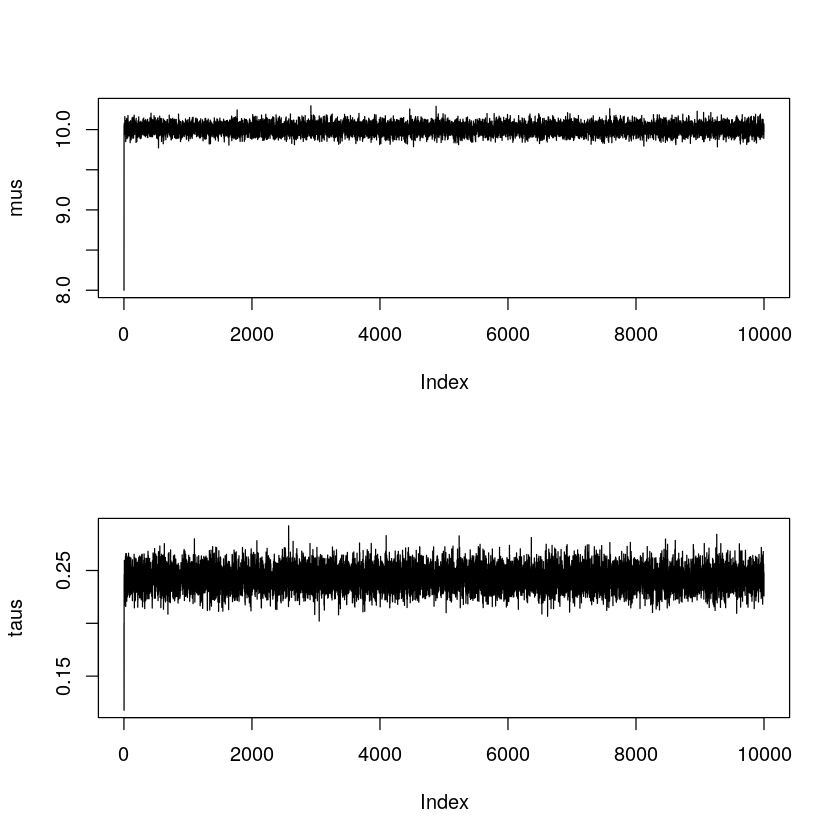

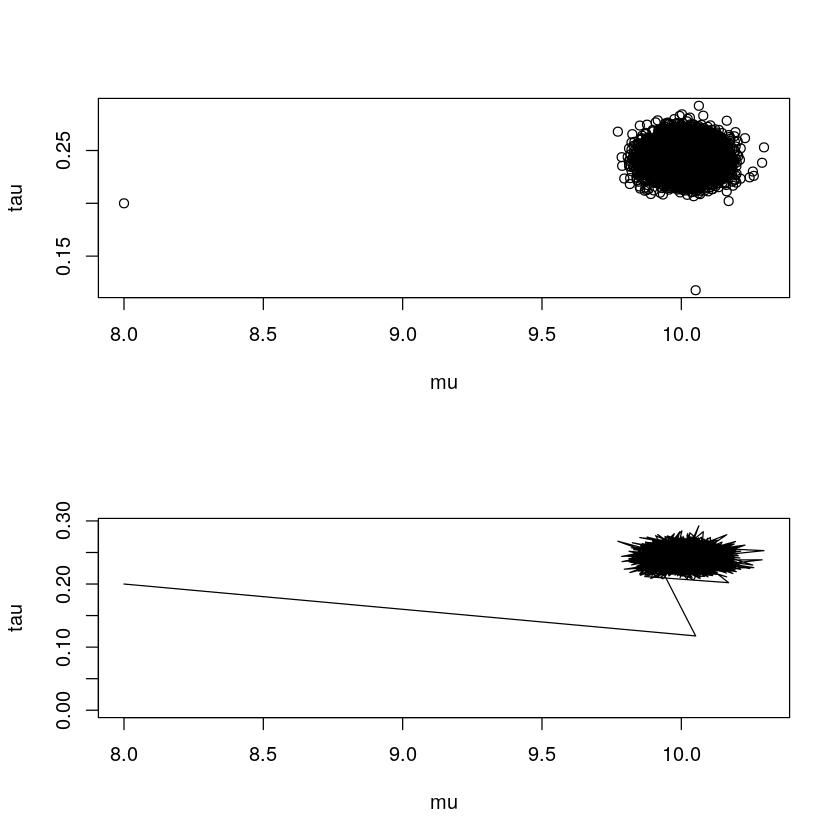

[1] "Estimated expected value of mu is: 10.0099952799664"
[1] "Estimated expected value of tau is: 0.242955342399553"
[1] "Estimated standard deviation of mu is: 0.0642325805834738"
[1] "Estimated standard deviation of tau is: 0.010895316181994"


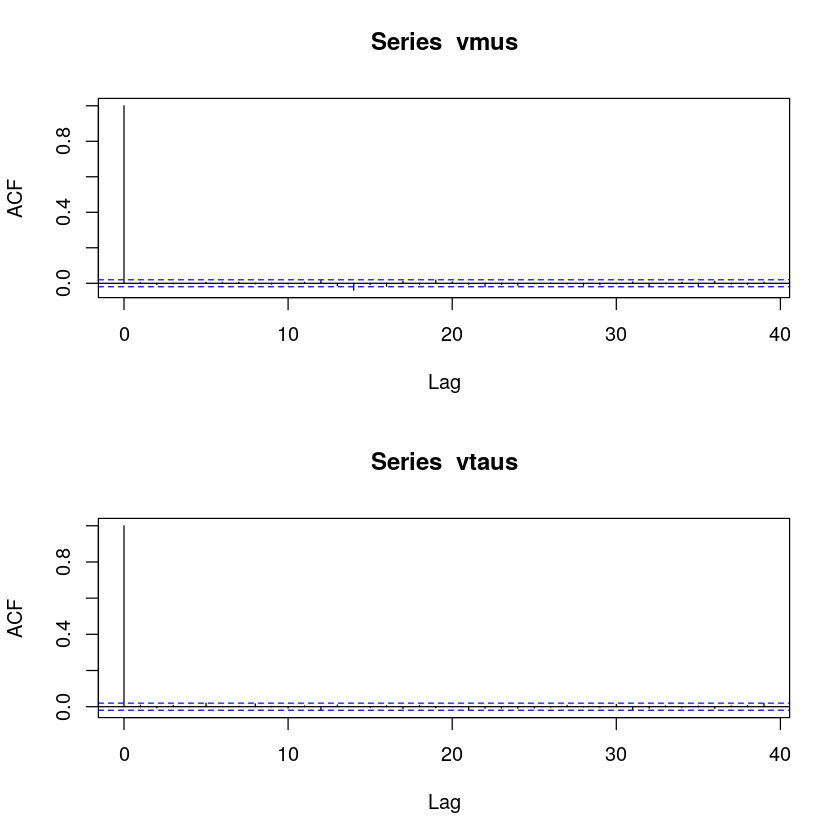

[1] "Effective sample size for mu is: 9989.99999999998"
[1] "Effective sample size for tau is: 9990.00000000003"
[1] "MCMC standard error of mu is: 6.42968774609348e-06"
[1] "MCMC standard error of tau is: 1.09062224043984e-06"


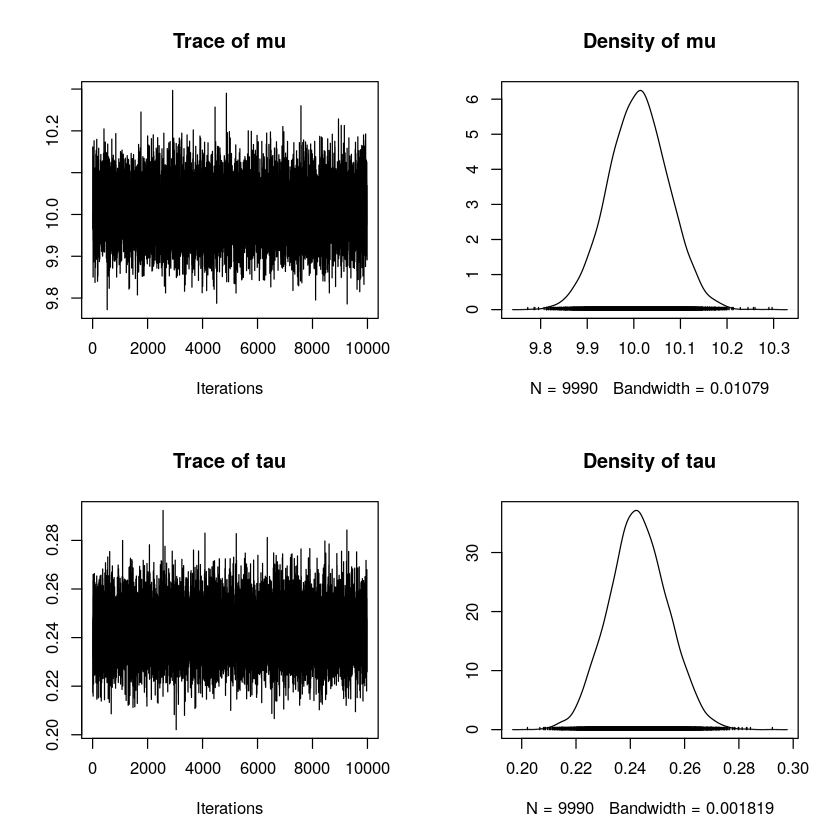

In [10]:
gibbsSample = gibbsNormGamma(8, 0.2, 10000, newparams)

plotMuTauSamp(gibbsSample)

computeAndPlotACFetc(gibbsSample, 10)

A reasonable choice of burn-in would appear to be around $10$ samples since the trace plots have stabilized by this point.

Here the conditional distributions needed for Gibbs sampling are Normal and Gamma, and there are R functions readily available to sample from them. What would you do if the conditional distributions were not as easily sampled from as they are here? 

You would need to build your own samplers for the conditional distributions, using, for example:
- Inverse transform sampling. This can be performed using a numerically computed cdf. Compute cumulative probabilities by numerical integration for all the values of interest and store them in a vector. Then, given a probability, find the closest values, one smaller, one larger, and interpolate.

- Rejection sampling. Can be used in the standard way. 

- Metropolis-Hastings. This might seem overkill, but sometimes it is the only way. Typically, only one iteraction is run, thereby generating one sample, but ignoring burn-in. 

Now write a random walk Metropolis-Hastings algorithm to generate samples from the distribution. You will need to run trials to find reasonable initial values of $\mu$ and $\tau$ for the Markov chain (try the MLEs) and of the proposal variances for $\mu$ and $\tau$. To do this, eyeball the traces and compute the acceptance rate as part of your functions.

In [27]:
dMNorm = function(x, mu, Sigma){
    
    E = 0.5 * (x - mu) %*% solve(Sigma) %*% (x - mu)
    
    Z = sqrt(det(2 * pi * Sigma))
    
    d = exp(-E) / Z

}


MHNormGamma = function(initmu, inittau, N, params, sigmaMu, sigmaTau){

    samples = matrix(vector(), 2, 0)
    print("hi")
    #print(samples)

    Sigma = matrix(c(sigmaMu, 0, 0, sigmaTau), nrow = 2, ncol = 2, byrow = TRUE) #diagonal matrix

    
    # Set initial values
    samples = cbind(samples, c(initmu, inittau))

    #print(samples[,2-1]) = mu and tau
    accepts = 0
  
  # MH sampling
  for (i in 2:N) {
      
      # Propose new values from multivariate Normal
      newVs = rmvn(1, samples[,i-1], Sigma)
      
      # Compute Qs and Ps. We do not really need this, since the proposal is symmetric.
      
      forwardQ = dMNorm(newVs, samples[,i-1], Sigma)
      backwardQ = dMNorm(samples[,i-1], newVs, Sigma)
      
#       print(paste('forwardQ', forwardQ))
#       print(paste('backwardQ', backwardQ))
      
      
      oldP = dNormGamma(samples[,i-1], newparams)
      newP = dNormGamma(newVs, newparams)
      
#       print(paste('oldP', oldP))
#       print(paste('newP', newP))
      
      # Compute ratio
      R = (backwardQ * newP) / (forwardQ * oldP)
      
#       print(R)
      accP = min(1, R)
      
      u = runif(1)
      
      accept = (u <= accP)
      
      accepts = accepts + accept
      
#       print(paste('accepts', accepts))
      
      if (accept){
          
          samples = cbind(samples, newVs)
      }
      else{
          
          samples = cbind(samples, samples[,i-1])
      }
    
  }
    
    mhResult = vector(mode = "list")
    
    mhResult$sample = samples
    mhResult$acceptR = accepts / N

    return(mhResult)
  
}

Now sample 10,000 values, and plot as before. Analyse with reference to the other methods and the theoretical values for mean and variances. 

[1] "hi"
      [,1]  [,2]
[1,] 3e-04 0e+00
[2,] 0e+00 3e-04
     [,1]
[1,]  8.0
[2,]  0.3
[1] 8.0 0.3
[1] "Accept rate =  0.531"


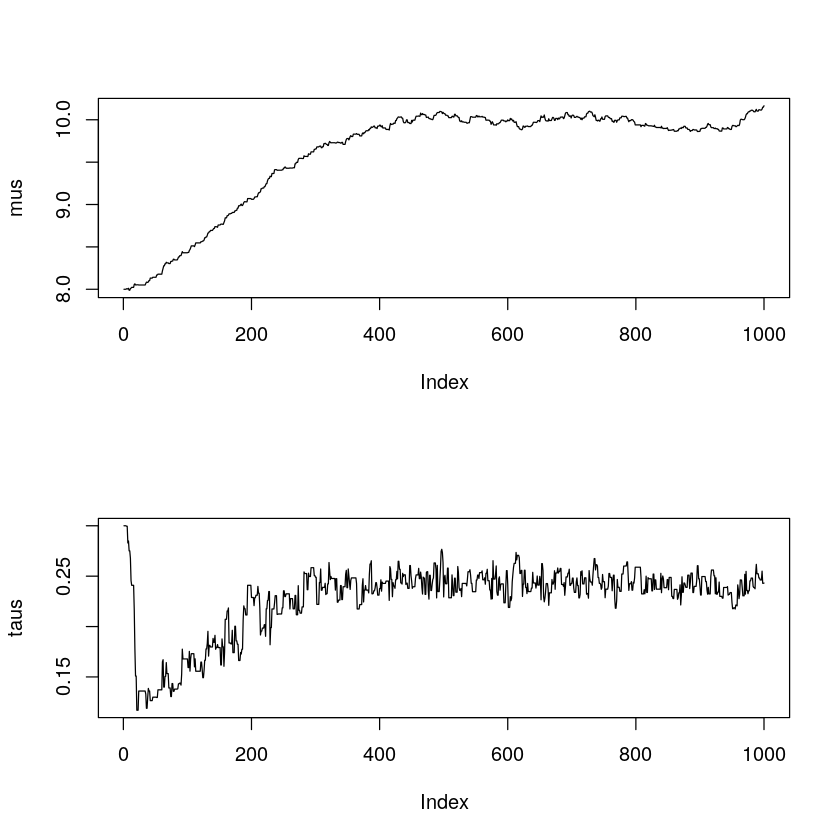

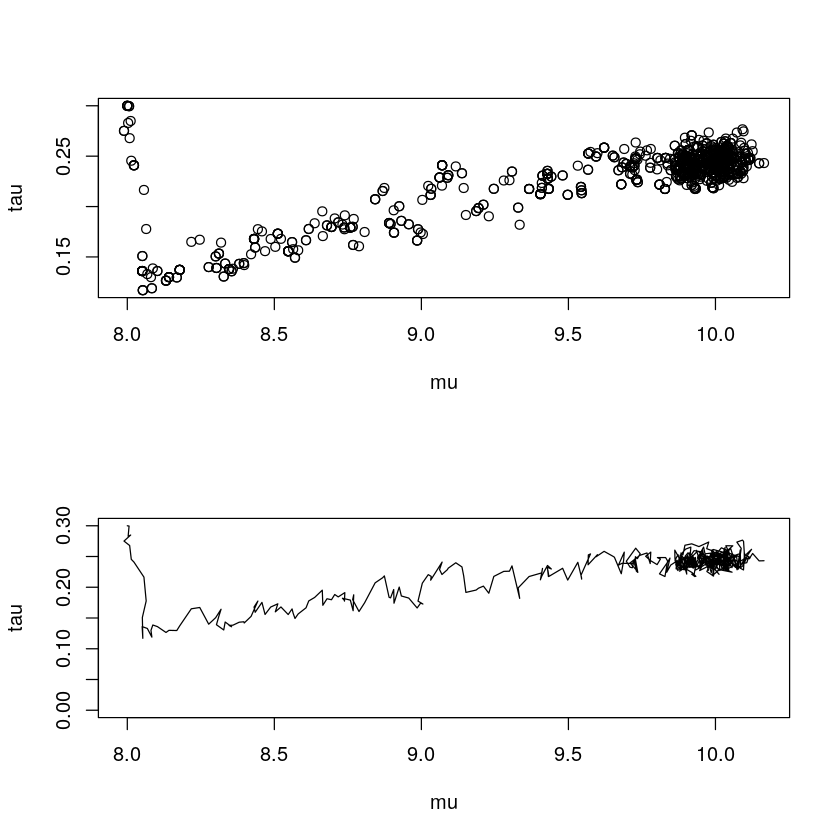

[1] "Estimated expected value of mu is: 9.95189225796369"
[1] "Estimated expected value of tau is: 0.241375712077265"
[1] "Estimated standard deviation of mu is: 0.0751386307649554"
[1] "Estimated standard deviation of tau is: 0.0100773382054988"


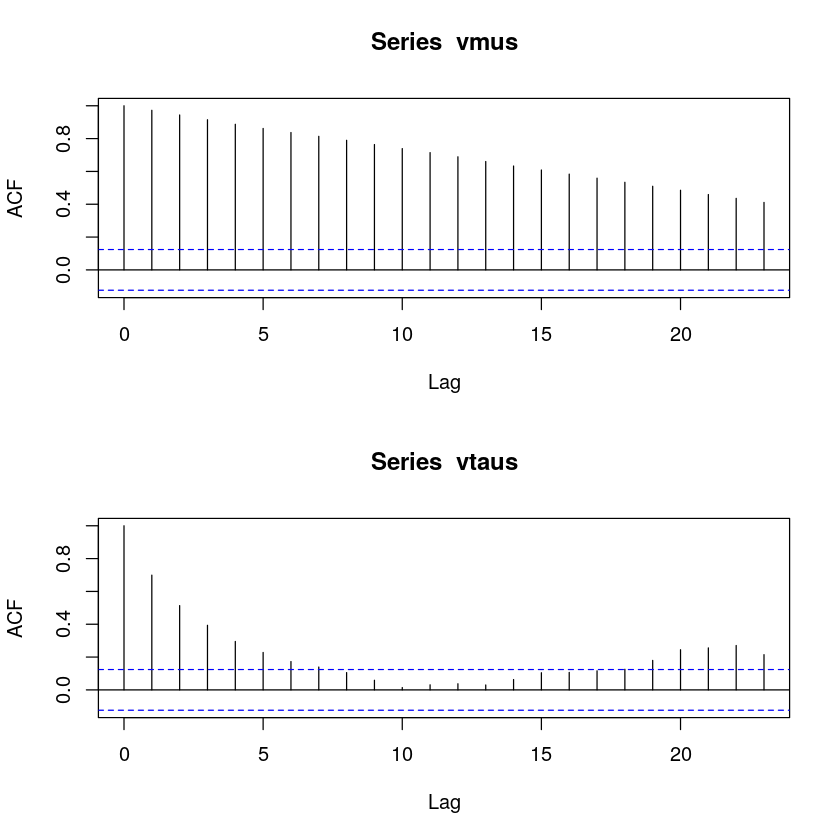

[1] "Effective sample size for mu is: 3.48983875425994"
[1] "Effective sample size for tau is: 44.1014694800594"
[1] "MCMC standard error of mu is: 0.0215306883944812"
[1] "MCMC standard error of tau is: 0.000228503456331661"


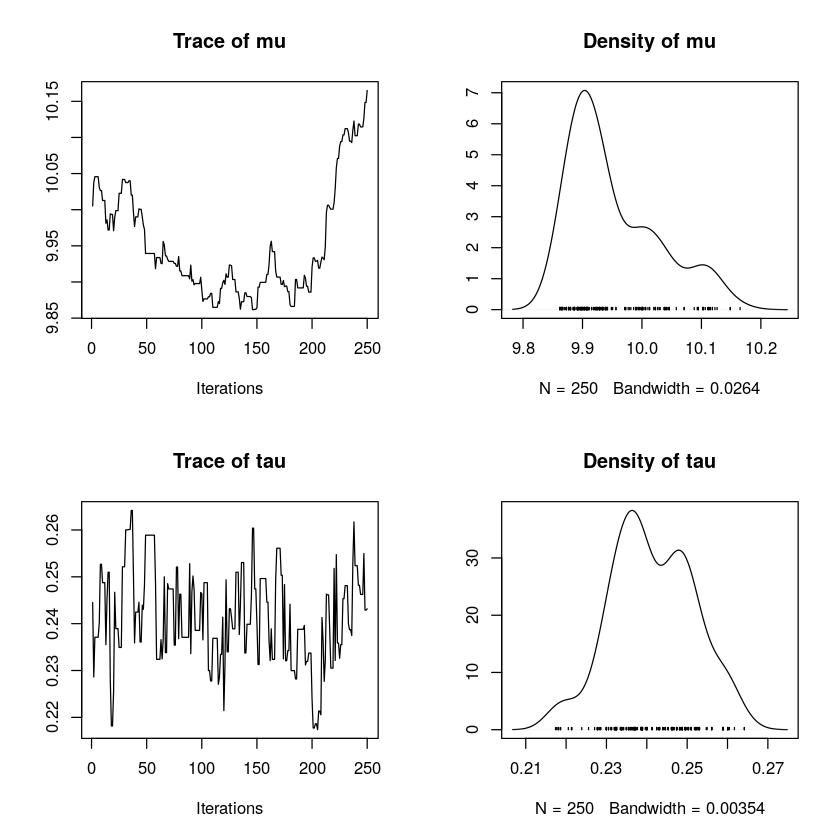

In [28]:
mhResult = MHNormGamma(8, 0.3, 1000, newparams, 0.0003, 0.0003)

mhSample = mhResult$sample

acceptRate = mhResult$acceptR

print(paste('Accept rate = ', acceptRate))

plotMuTauSamp(mhSample)

computeAndPlotACFetc(mhSample, 750)

Why is there such a big difference between Gibbs sampling and Metropolis-Hastings in this example?

In the very first method, successive samples are independent. Although this is not longer exactly true in Gibbs sampling, the similarity between the two methods means that Gibbs sampling is very efficient in this context. On the other hand, Metropolis-Hastings has no such advantage, and behaves more typically. 

You might like to check out the packages:
- JAGS (Just Another Gibbs Sampler)
- BUGS (Bayesian inference Using Gibbs Sampling)
- STAN

Other options include: 
- MCMCpack
- MCMC R Package